In [1]:
import pandas as pd
from json import loads

# SCENIC gene modules

In [2]:
def get_target_genes(genestr):
    target = eval(genestr)
    target = [pair[0] for pair in target]
    return target


In [3]:
reg = pd.read_csv('./abm_regulons_seed1.csv',index_col=[0,1], header=[0,1])
reg = reg.droplevel(0,axis=1).reset_index()

tf2target = {}
for tf, tg in zip(reg['TF'], reg['TargetGenes']):
    if tf not in tf2target.keys():
        tf2target[tf] = set(get_target_genes(tg))
    else:
        tf2target[tf].update(set(get_target_genes(tg)))
tf2target_abm =tf2target


In [4]:
reg = pd.read_csv('./fl_regulons_seed1.csv',index_col=[0,1], header=[0,1])
reg = reg.droplevel(0,axis=1).reset_index()

tf2target = {}
for tf, tg in zip(reg['TF'], reg['TargetGenes']):
    if tf not in tf2target.keys():
        tf2target[tf] = set(get_target_genes(tg))
    else:
        tf2target[tf].update(set(get_target_genes(tg)))
tf2target_fl =tf2target


In [5]:
target2tf = {}
for tf,target_list in tf2target.items():
    for target_gene in target_list:
        if target_gene not in target2tf:
            target2tf[target_gene] = {tf}
        else:
            target2tf[target_gene].update({tf})

In [9]:
pd.DataFrame(list(target2tf['Gata3']))

,0
0,Rest
1,Dmrta1
2,Bclaf1
3,Klf10
4,Tcf7
5,Stat1
6,Hoxa5
7,Ets1
8,Zbtb16


In [8]:
pd.DataFrame(list(tf2target_abm['Rbpj']))

,0
0,Tln2
1,Wnt9a
2,Rbpj
3,Hes1
4,AI854703
5,M1ap
6,Zfp90
7,Prkch


In [265]:
pd.DataFrame(list(tf2target_abm['Gata3'])).to_csv('./abm-Gata3Regulon.csv',index=False)
pd.DataFrame(list(tf2target_abm['Rorc'])).to_csv('./abm-RorcRegulon.csv',index=False)
pd.DataFrame(list(tf2target_fl['Gata3'])).to_csv('./fl-Gata3Regulon.csv',index=False)
pd.DataFrame(list(tf2target_fl['Rorc'])).to_csv('./fl-RorcRegulon.csv',index=False)

# trend clustering 

## ABM trends

In [187]:
import rpy2.robjects as robjects

readRDS = robjects.r['readRDS']
abm_gene_mod = readRDS('/home/csj/mywork/ilc/221107-path/221122-ABM.Mfuzz.gene.modules.rds')

mod2member = {}
for module_name in ['G4','G5','G6','G7','G2','G3','G1']:
    module_genes=list(abm_gene_mod.rx2( module_name ).rx2('gene'))
    mod2member[module_name] = module_genes
    
mod2member_abm= mod2member

In [188]:
import rpy2.robjects as robjects

readRDS = robjects.r['readRDS']
fl_gene_mod = readRDS('/home/csj/mywork/ilc/221107-path/221122-FL.Mfuzz.gene.modules.rds')

mod2member = {}
for module_name in ['G5','G4','G1','G3','G2']:
    module_genes=list(abm_gene_mod.rx2( module_name ).rx2('gene'))
    mod2member[module_name] = module_genes
    
mod2member_fl= mod2member

# find important regulons

In [189]:
def intersect(a, b):
    """ return the intersection of two lists """
    return list(set(a) & set(b))

def union(a, b):
    """ return the union of two lists """
    return list(set(a) | set(b))

def iou(a,b):
    return len(intersect(a,b)) / len(union(a,b))



In [190]:
tf2target = tf2target_abm
mod2member =  mod2member_abm

data=[]
for tf in tf2target.keys():
    regulon= list(set(list(tf2target[tf])+[tf]))
    rowitem = {}
    for modname, modmembers in mod2member.items():
        rowitem[modname] = iou(regulon, modmembers)
    data.append(rowitem)    
    
regulon_module_iou_abm = pd.DataFrame(data, index=tf2target.keys())

In [191]:
tf2target = tf2target_fl
mod2member =  mod2member_fl

data=[]
for tf in tf2target.keys():
    regulon= list(set(list(tf2target[tf])+[tf]))
    rowitem = {}
    for modname, modmembers in mod2member.items():
        rowitem[modname] = iou(regulon, modmembers)
    data.append(rowitem)    
    
regulon_module_iou_fl = pd.DataFrame(data, index=tf2target.keys())

In [194]:
regulon_module_iou_fl

,G5,G4,G1,G3,G2
Ar,0.000000,0.000000,0.000000,0.000000,0.006211
Arnt,0.004854,0.005155,0.000000,0.000000,0.004762
Atf1,0.005181,0.000000,0.007092,0.000000,0.000000
Atf3,0.017045,0.011696,0.011287,0.009153,0.016854
Atf6,0.000000,0.000000,0.006849,0.003497,0.009709
...,...,...,...,...,...
Stat2,0.000000,0.000000,0.000000,0.007722,0.005525
Zfp503,0.006024,0.000000,0.003906,0.000000,0.005882
Zfp771,0.000000,0.000000,0.000000,0.000000,0.000000
Smc3,0.008969,0.000000,0.000000,0.000000,0.000000


In [209]:
?sns.clustermap

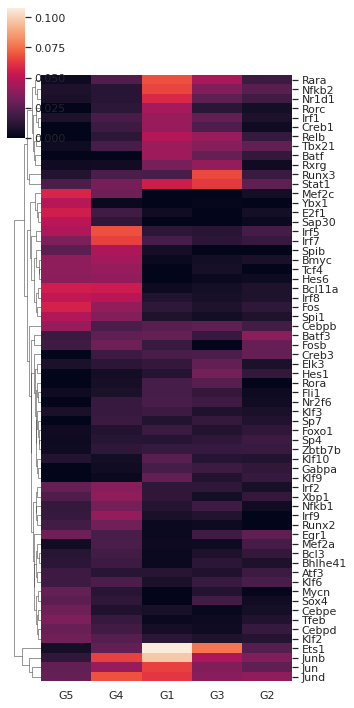

In [239]:
regulon_selected = regulon_module_iou_fl[regulon_module_iou_fl.sum(axis=1)>0.05]
import seaborn as sns; 
sns.set(rc={'figure.figsize':(15.7,8.27)})
g = sns.clustermap(regulon_selected, col_cluster=False, dendrogram_ratio=0.1,yticklabels=True, figsize=(5,10))

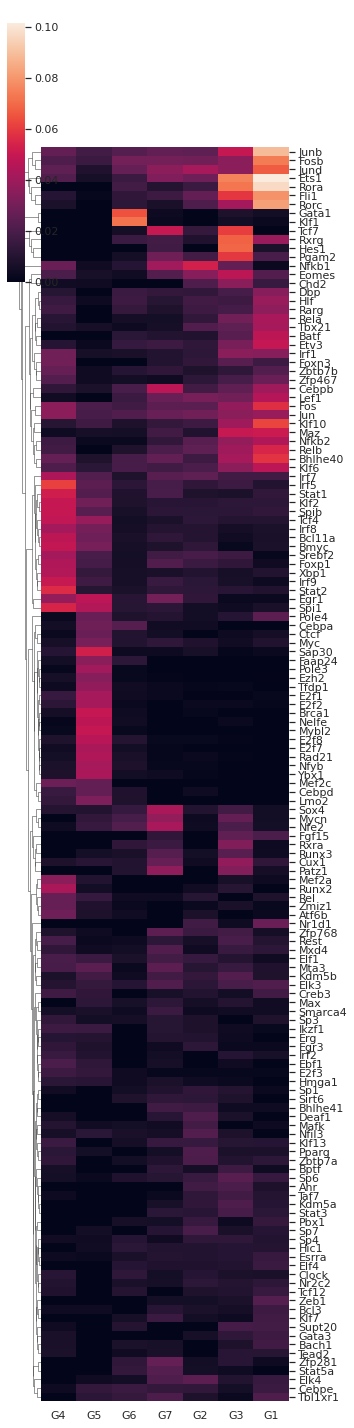

In [235]:
regulon_selected = regulon_module_iou_abm[regulon_module_iou_abm.sum(axis=1)>0.04]
import seaborn as sns,matplotlib.pyplot as plt

g = sns.clustermap(regulon_selected, col_cluster=False, dendrogram_ratio=0.1,yticklabels=True, figsize=(5,20))